<a href="https://colab.research.google.com/github/justinshenk/temporal-awareness/blob/main/notebooks/02_spd_parameter_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Parameter Decomposition (SPD) Experiments

> **Note:** Results in this notebook are pending human verification.

This notebook replicates key results from the paper:

**"Stochastic Parameter Decomposition"** by Bushnaq, Braun, and Sharkey (2025)

Paper: https://arxiv.org/abs/2506.20790  
Code: https://github.com/goodfire-ai/spd/tree/spd-paper

## Overview

SPD is a method for decomposing neural network parameters into interpretable subcomponents. The key idea is to find a decomposition:

$$W = \sum_{c=1}^{C} A_c B_c$$

where each component $(A_c, B_c)$ corresponds to a specific "mechanism" or "feature" that the network has learned.

### Key Innovations over APD (Attribution-based Parameter Decomposition):
1. **Stochastic masking** - More robust to hyperparameters
2. **Improved scalability** - Works on larger models
3. **No parameter shrinkage** - Maintains model behavior better

## Setup

In [1]:
# Colab setup - clone SPD repo and install dependencies
# Skip this cell if running locally

import os
if 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython()):
    !git clone -b spd-paper https://github.com/goodfire-ai/spd.git ../spd_repo
    !pip install -e ../spd_repo
    print("SPD installed successfully!")

Cloning into '../spd_repo'...
remote: Enumerating objects: 33777, done.
remote: Counting objects: 100% (1175/1175), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 33777 (delta 1050), reused 921 (delta 909), pack-reused 32602 (from 2)
Receiving objects: 100% (33777/33777), 175.71 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (23551/23551), done.
Obtaining file:///spd_repo
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the Windows wheels to prevent these segfaults, however this caused greater disruption as pip then began to try 

SPD installed successfully!


In [2]:
import sys
sys.path.insert(0, '../spd_repo')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import yaml

# Add set_submodule polyfill for PyTorch < 2.1
if not hasattr(nn.Module, 'set_submodule'):
    def set_submodule(self, target: str, module: nn.Module) -> None:
        '''Set a submodule by its target path (e.g., 'layer.sublayer.module').'''
        parts = target.split('.')
        parent = self
        for part in parts[:-1]:
            parent = getattr(parent, part)
        setattr(parent, parts[-1], module)
    nn.Module.set_submodule = set_submodule
    print("Added set_submodule polyfill for PyTorch compatibility")

# SPD imports
from spd.experiments.tms.models import TMSModel, TMSModelConfig
from spd.experiments.tms.train_tms import TMSTrainConfig, train, get_model_and_dataloader
from spd.data_utils import DatasetGeneratedDataLoader, SparseFeatureDataset
from spd.configs import Config, TMSTaskConfig
from spd.run_spd import optimize
from spd.plotting import create_toy_model_plot_results, plot_causal_importance_vals, plot_AB_matrices
from spd.models.component_model import ComponentModel
from spd.models.components import LinearComponent, EmbeddingComponent, Gate, GateMLP
from spd.models.component_utils import calc_causal_importances
from spd.utils import set_seed

# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.


Using device: cuda


## Part 1: Train a Toy Model of Superposition (TMS)

The TMS model is a simple autoencoder that learns to represent more features than it has hidden dimensions - this is called **superposition**. The model architecture is:

$$\text{output} = \text{ReLU}(W^T W x + b)$$

where $W \in \mathbb{R}^{n_{hidden} \times n_{features}}$ with $n_{hidden} < n_{features}$.

In [3]:
# TMS 5-2 Configuration: 5 features compressed into 2 hidden dimensions
set_seed(42)

tms_train_config = TMSTrainConfig(
    wandb_project=None,  # No wandb logging
    tms_model_config=TMSModelConfig(
        n_features=5,
        n_hidden=2,
        n_hidden_layers=1,  # One additional hidden layer
        tied_weights=True,
        device=device,
        init_bias_to_zero=False,
    ),
    feature_probability=0.05,  # Sparse features
    batch_size=1024,
    steps=5000,  # Reduced for faster training
    seed=42,
    lr=5e-3,
    lr_schedule="constant",
    data_generation_type="at_least_zero_active",
    fixed_identity_hidden_layers=True,  # Fix hidden layer to identity
    fixed_random_hidden_layers=False,
)

print("TMS Model Configuration:")
print(f"  - Features: {tms_train_config.tms_model_config.n_features}")
print(f"  - Hidden dims: {tms_train_config.tms_model_config.n_hidden}")
print(f"  - Superposition ratio: {tms_train_config.tms_model_config.n_features / tms_train_config.tms_model_config.n_hidden:.1f}x")

TMS Model Configuration:
  - Features: 5
  - Hidden dims: 2
  - Superposition ratio: 2.5x


In [4]:
# Create model and dataloader
tms_model, dataloader = get_model_and_dataloader(tms_train_config, device)

print(f"\nModel parameters: {sum(p.numel() for p in tms_model.parameters())}")
print(f"\nModel architecture:")
print(tms_model)


Model parameters: 29

Model architecture:
TMSModel(
  (linear1): Linear(in_features=5, out_features=2, bias=False)
  (linear2): Linear(in_features=2, out_features=5, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=False)
  )
)


In [5]:
# Train the TMS model
print("Training TMS model...")
print("(This should take ~30-60 seconds on CPU)\n")

train(
    tms_model,
    dataloader=dataloader,
    log_wandb=False,
    steps=tms_train_config.steps,
    importance=1.0,
    print_freq=1000,
    lr=tms_train_config.lr,
    lr_schedule=tms_train_config.lr_schedule,
)

print("\nTraining complete!")

Training TMS model...
(This should take ~30-60 seconds on CPU)



  1% 30/5000 [00:00<01:17, 64.05it/s, loss=0.0558, lr=0.005]

Step 0 Loss: 0.0557594895362854


 21% 1044/5000 [00:03<00:09, 405.47it/s, loss=0.0105, lr=0.005]

Step 1000 Loss: 0.010518111288547516


 41% 2066/5000 [00:07<00:08, 362.65it/s, loss=0.0092, lr=0.005]

Step 2000 Loss: 0.009200072847306728


 62% 3104/5000 [00:08<00:02, 702.12it/s, loss=0.0105, lr=0.005]

Step 3000 Loss: 0.010541277937591076


 82% 4110/5000 [00:10<00:01, 690.77it/s, loss=0.00963, lr=0.005]

Step 4000 Loss: 0.009628198109567165


100% 5000/5000 [00:11<00:00, 434.49it/s, loss=0.00957, lr=0.005]

Step 4999 Loss: 0.009571117348968983

Training complete!


In [6]:
# Save the trained model
out_dir = Path("../results/spd_experiments")
out_dir.mkdir(parents=True, exist_ok=True)

model_path = out_dir / "tms_5_2.pth"
torch.save(tms_model.state_dict(), model_path)

# Save config
config_path = out_dir / "tms_train_config.yaml"
with open(config_path, "w") as f:
    yaml.dump(tms_train_config.model_dump(mode="json"), f, indent=2)

print(f"Saved model to {model_path}")
print(f"Saved config to {config_path}")

Saved model to ../results/spd_experiments/tms_5_2.pth
Saved config to ../results/spd_experiments/tms_train_config.yaml


## Part 2: Visualize the Learned Superposition

Before running SPD, let's visualize what the model has learned. In 2D, we can plot the learned feature vectors as arrows from the origin.

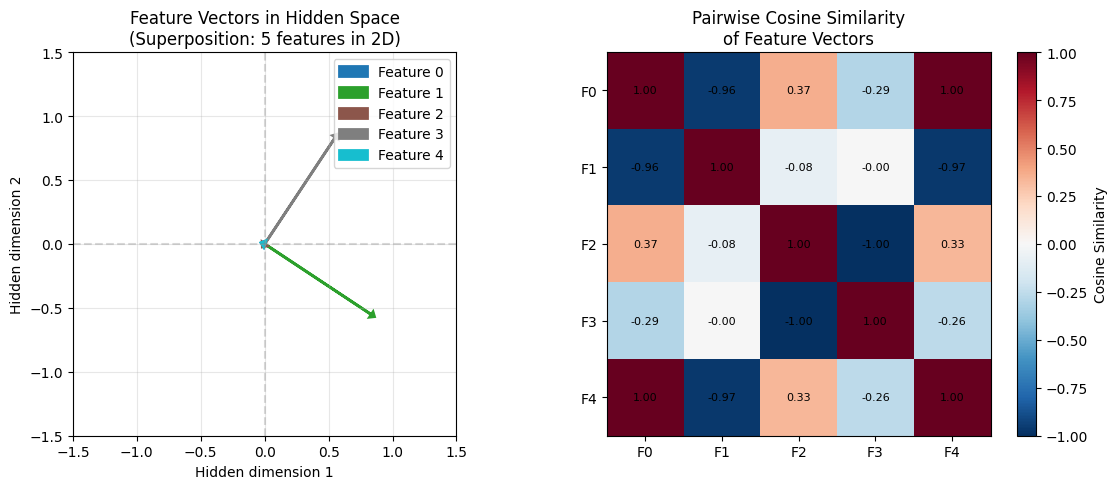


Observation: The model has learned to pack 5 features into 2 dimensions.
Notice how the vectors are arranged to minimize interference (negative cosine similarity).


In [7]:
# Plot the 2D feature embedding
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get the weight matrix (features embedded in 2D hidden space)
W = tms_model.linear1.weight.T.detach().cpu().numpy()  # Shape: (n_features, n_hidden)

# Plot 1: Feature vectors as arrows
ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, W.shape[0]))

for i, (vec, color) in enumerate(zip(W, colors)):
    ax1.arrow(0, 0, vec[0], vec[1], head_width=0.05, head_length=0.03,
              fc=color, ec=color, linewidth=2, label=f'Feature {i}')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.set_xlabel('Hidden dimension 1')
ax1.set_ylabel('Hidden dimension 2')
ax1.set_title('Feature Vectors in Hidden Space\n(Superposition: 5 features in 2D)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Pairwise cosine similarities
ax2 = axes[1]
W_normalized = W / np.linalg.norm(W, axis=1, keepdims=True)
cosine_sim = W_normalized @ W_normalized.T

im = ax2.imshow(cosine_sim, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_xticks(range(W.shape[0]))
ax2.set_yticks(range(W.shape[0]))
ax2.set_xticklabels([f'F{i}' for i in range(W.shape[0])])
ax2.set_yticklabels([f'F{i}' for i in range(W.shape[0])])
ax2.set_title('Pairwise Cosine Similarity\nof Feature Vectors')
plt.colorbar(im, ax=ax2, label='Cosine Similarity')

# Add text annotations
for i in range(W.shape[0]):
    for j in range(W.shape[0]):
        ax2.text(j, i, f'{cosine_sim[i,j]:.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(out_dir / "tms_superposition_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nObservation: The model has learned to pack 5 features into 2 dimensions.")
print("Notice how the vectors are arranged to minimize interference (negative cosine similarity).")

In [8]:
# Test the model's reconstruction quality
print("Testing feature reconstruction quality...\n")

test_value = 0.75
n_features = tms_train_config.tms_model_config.n_features
output_values = []

tms_model.eval()
with torch.no_grad():
    for i in range(n_features):
        # Create input with single active feature
        batch = torch.zeros(1, n_features, device=device)
        batch[0, i] = test_value

        out = tms_model(batch)
        output_values.append(out[0, i].item())
        print(f"Feature {i}: input={test_value:.3f} -> output={out[0, i].item():.3f} (error={abs(out[0, i].item() - test_value):.3f})")

output_values = np.array(output_values)
print(f"\nMean reconstruction: {output_values.mean():.3f} (target: {test_value})")
print(f"Mean absolute error: {np.abs(output_values - test_value).mean():.3f}")

Testing feature reconstruction quality...

Feature 0: input=0.750 -> output=0.000 (error=0.750)
Feature 1: input=0.750 -> output=0.750 (error=0.000)
Feature 2: input=0.750 -> output=0.000 (error=0.750)
Feature 3: input=0.750 -> output=0.750 (error=0.000)
Feature 4: input=0.750 -> output=0.000 (error=0.750)

Mean reconstruction: 0.300 (target: 0.75)
Mean absolute error: 0.450


## Part 3: Run Stochastic Parameter Decomposition (SPD)

Now we run SPD to decompose the model parameters into interpretable subcomponents. The goal is to find:

$$W = \sum_{c=1}^{C} A_c B_c$$

where ideally each component $(A_c, B_c)$ corresponds to one of the 5 input features.

In [9]:
# SPD Configuration
set_seed(0)

spd_config = Config(
    # No wandb
    wandb_project=None,
    wandb_run_name=None,
    wandb_run_name_prefix="",

    # General
    seed=0,
    C=20,  # Number of subcomponents (should be >= n_features)
    n_mask_samples=1,
    n_ci_mlp_neurons=16,  # MLP neurons for causal importance calculation
    target_module_patterns=["linear1", "linear2", "hidden_layers.0"],

    # Loss Coefficients
    faithfulness_coeff=1.0,
    recon_coeff=None,
    stochastic_recon_coeff=1.0,
    recon_layerwise_coeff=None,
    stochastic_recon_layerwise_coeff=1.0,
    importance_minimality_coeff=3e-3,
    pnorm=1.0,
    output_loss_type="mse",

    # Training
    batch_size=4096,
    steps=5000,  # Reduced for faster demo
    lr=1e-3,
    lr_schedule="cosine",
    lr_warmup_pct=0.0,
    n_eval_steps=100,

    # Logging
    image_freq=2500,
    print_freq=1000,
    save_freq=None,

    # Model info
    pretrained_model_class="spd.experiments.tms.models.TMSModel",
    pretrained_model_path=str(model_path),

    # Task config
    task_config=TMSTaskConfig(
        task_name="tms",
        feature_probability=0.05,
        data_generation_type="at_least_zero_active",
    ),
)

print("SPD Configuration:")
print(f"  - Components (C): {spd_config.C}")
print(f"  - Training steps: {spd_config.steps}")
print(f"  - Target modules: {spd_config.target_module_patterns}")

SPD Configuration:
  - Components (C): 20
  - Training steps: 5000
  - Target modules: ['linear1', 'linear2', 'hidden_layers.0']


In [10]:
# Prepare for SPD optimization
tms_model.eval()
for param in tms_model.parameters():
    param.requires_grad = False

# Create data loaders for SPD training
dataset = SparseFeatureDataset(
    n_features=tms_model.config.n_features,
    feature_probability=spd_config.task_config.feature_probability,
    device=device,
    data_generation_type=spd_config.task_config.data_generation_type,
    value_range=(0.0, 1.0),
    synced_inputs=None,
)

train_loader = DatasetGeneratedDataLoader(dataset, batch_size=spd_config.batch_size, shuffle=False)
eval_loader = DatasetGeneratedDataLoader(dataset, batch_size=spd_config.batch_size, shuffle=False)

# Set up tied weights for the TMS model
tied_weights = None
if tms_model.config.tied_weights:
    tied_weights = [("linear1", "linear2")]

print("Data loaders created.")
print(f"Tied weights: {tied_weights}")

Data loaders created.
Tied weights: [('linear1', 'linear2')]


2025-12-03 14:26:35 - INFO - Target model parameters frozen.
2025-12-03 14:26:35 - INFO - Base LR scheduler created: cosine


Running SPD optimization...
(This should take ~2-5 minutes on CPU)



  0% 0/5001 [00:00<?, ?it/s]

--- Step 0 ---
LR: 0.001000
Total Loss: 1.9707147
loss/faithfulness: 1.9142002
loss/stochastic_recon: 0.0426524
loss/stochastic_recon_layerwise: 0.0120456
loss/importance_minimality: 0.6054704


2025-12-03 14:26:35 - INFO - Step 0: Generating plots...
 20% 1009/5001 [00:15<00:57, 69.23it/s]

--- Step 1000 ---
LR: 0.000951
Total Loss: 0.0036211
loss/faithfulness: 0.0000338
loss/stochastic_recon: 0.0014984
loss/stochastic_recon_layerwise: 0.0007421
loss/importance_minimality: 0.4489002


 40% 2003/5001 [00:30<00:57, 52.17it/s]

--- Step 2000 ---
LR: 0.000809
Total Loss: 0.0022567
loss/faithfulness: 0.0000084
loss/stochastic_recon: 0.0007577
loss/stochastic_recon_layerwise: 0.0004357
loss/importance_minimality: 0.3516450


 50% 2495/5001 [00:37<00:34, 73.58it/s]2025-12-03 14:27:12 - INFO - Step 2500: Generating plots...
 60% 3013/5001 [00:45<00:28, 70.09it/s]

--- Step 3000 ---
LR: 0.000588
Total Loss: 0.0021861
loss/faithfulness: 0.0000025
loss/stochastic_recon: 0.0006902
loss/stochastic_recon_layerwise: 0.0003796
loss/importance_minimality: 0.3712638


 80% 4011/5001 [00:59<00:13, 73.21it/s]

--- Step 4000 ---
LR: 0.000309
Total Loss: 0.0017602
loss/faithfulness: 0.0000023
loss/stochastic_recon: 0.0005258
loss/stochastic_recon_layerwise: 0.0003026
loss/importance_minimality: 0.3098203


100% 5000/5001 [01:13<00:00, 75.86it/s]2025-12-03 14:27:48 - INFO - Step 5000: Generating plots...


--- Step 5000 ---
LR: -0.000000
Total Loss: 0.0018751
loss/faithfulness: 0.0000019
loss/stochastic_recon: 0.0005766
loss/stochastic_recon_layerwise: 0.0002836
loss/importance_minimality: 0.3376340


/content/../spd_repo/spd/plotting.py:388: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)
2025-12-03 14:27:50 - INFO - Saved model, optimizer, and out_dir to ../results/spd_experiments/spd_decomposition
100% 5001/5001 [01:14<00:00, 66.89it/s]
2025-12-03 14:27:50 - INFO - Finished training loop.



SPD optimization complete!


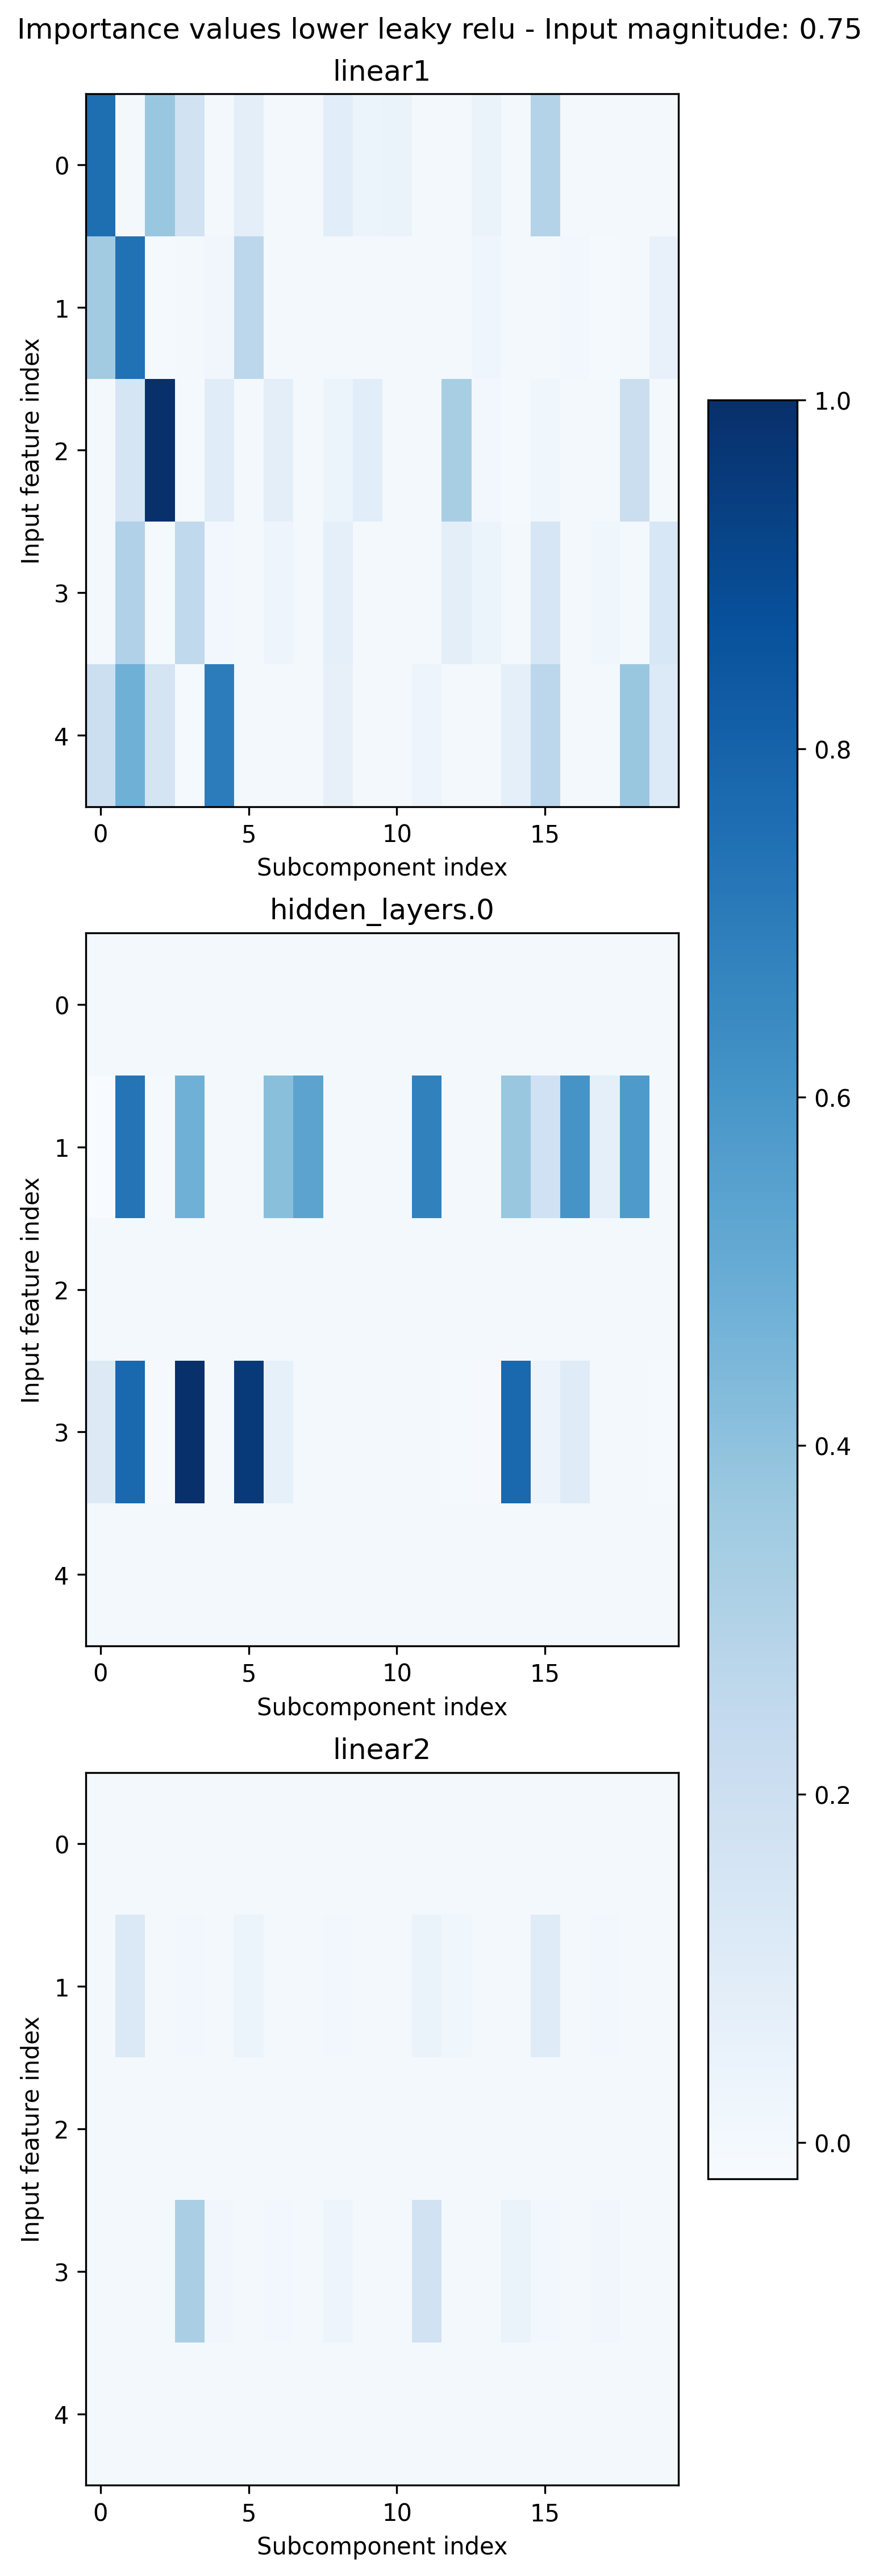

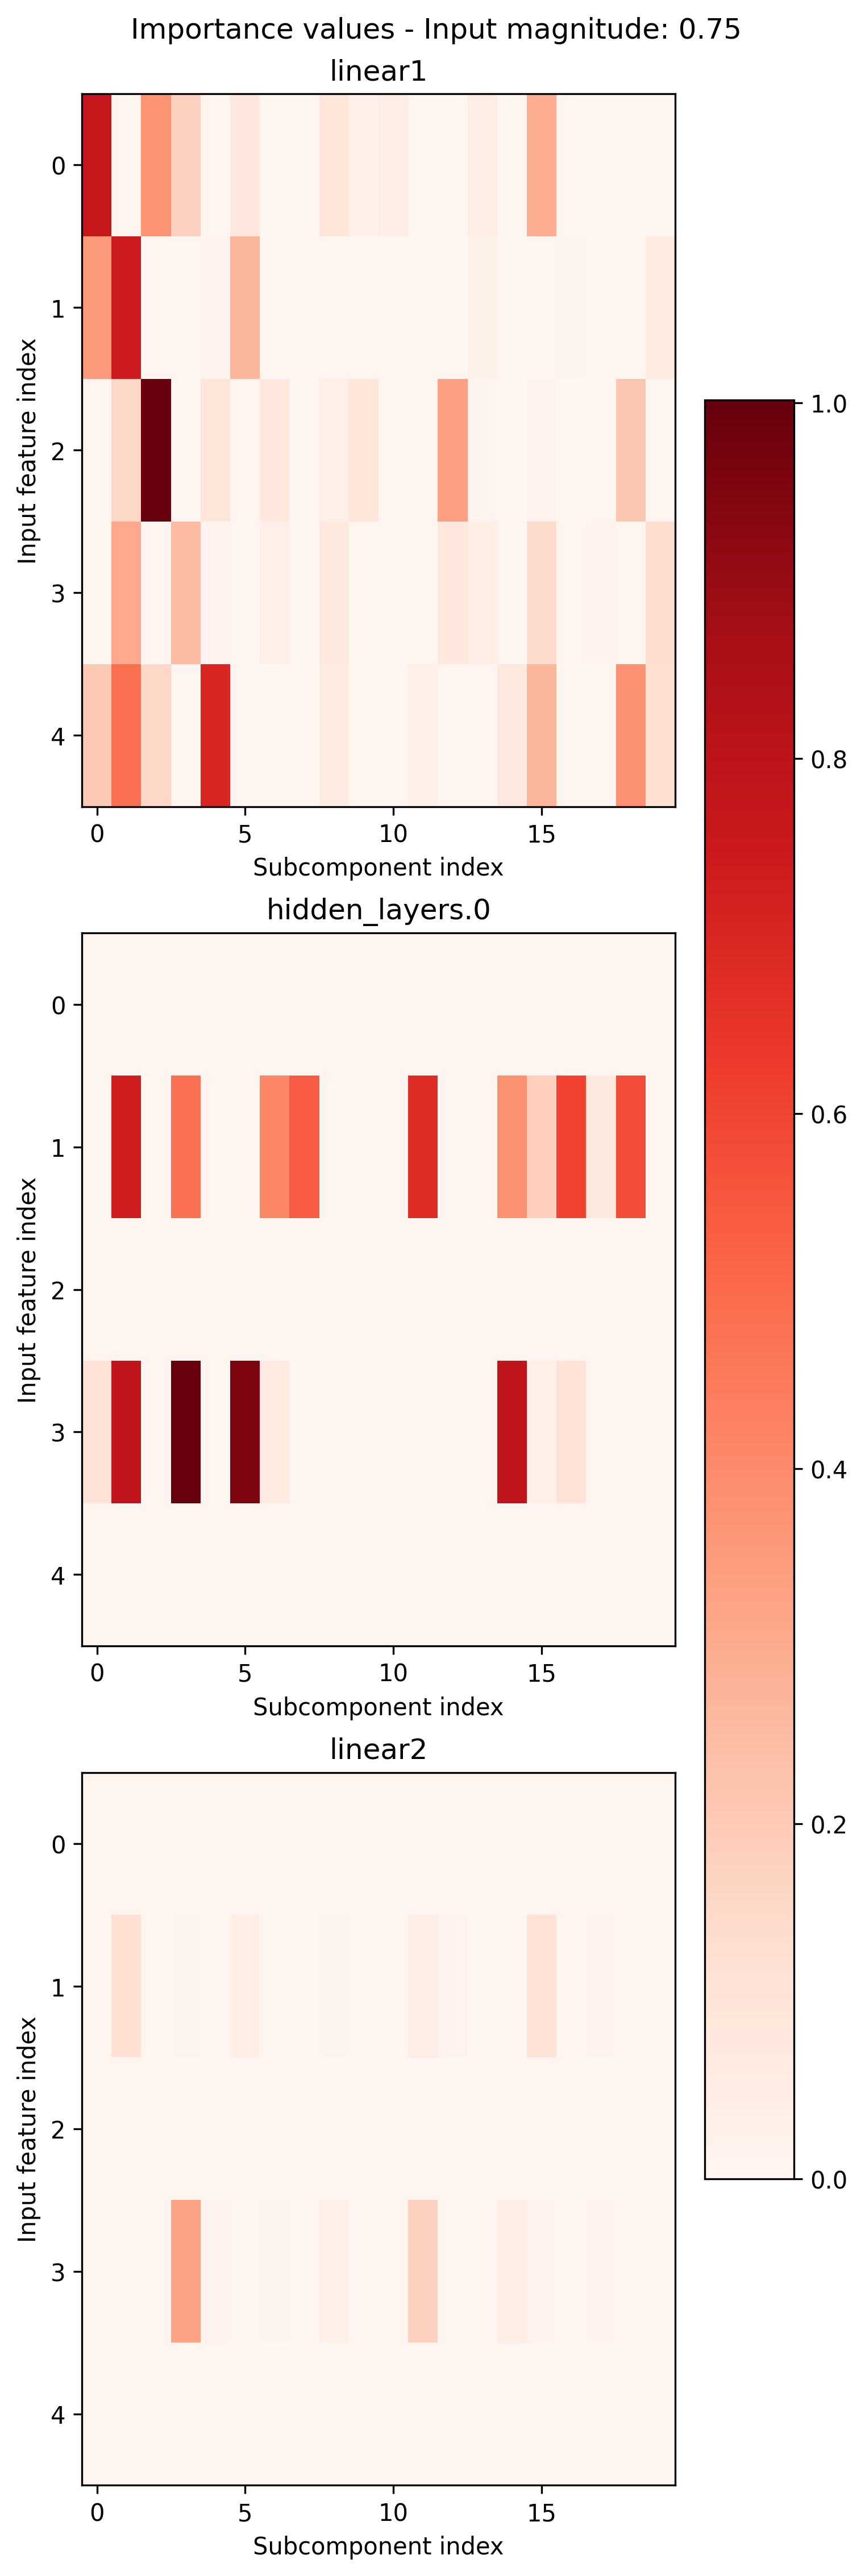

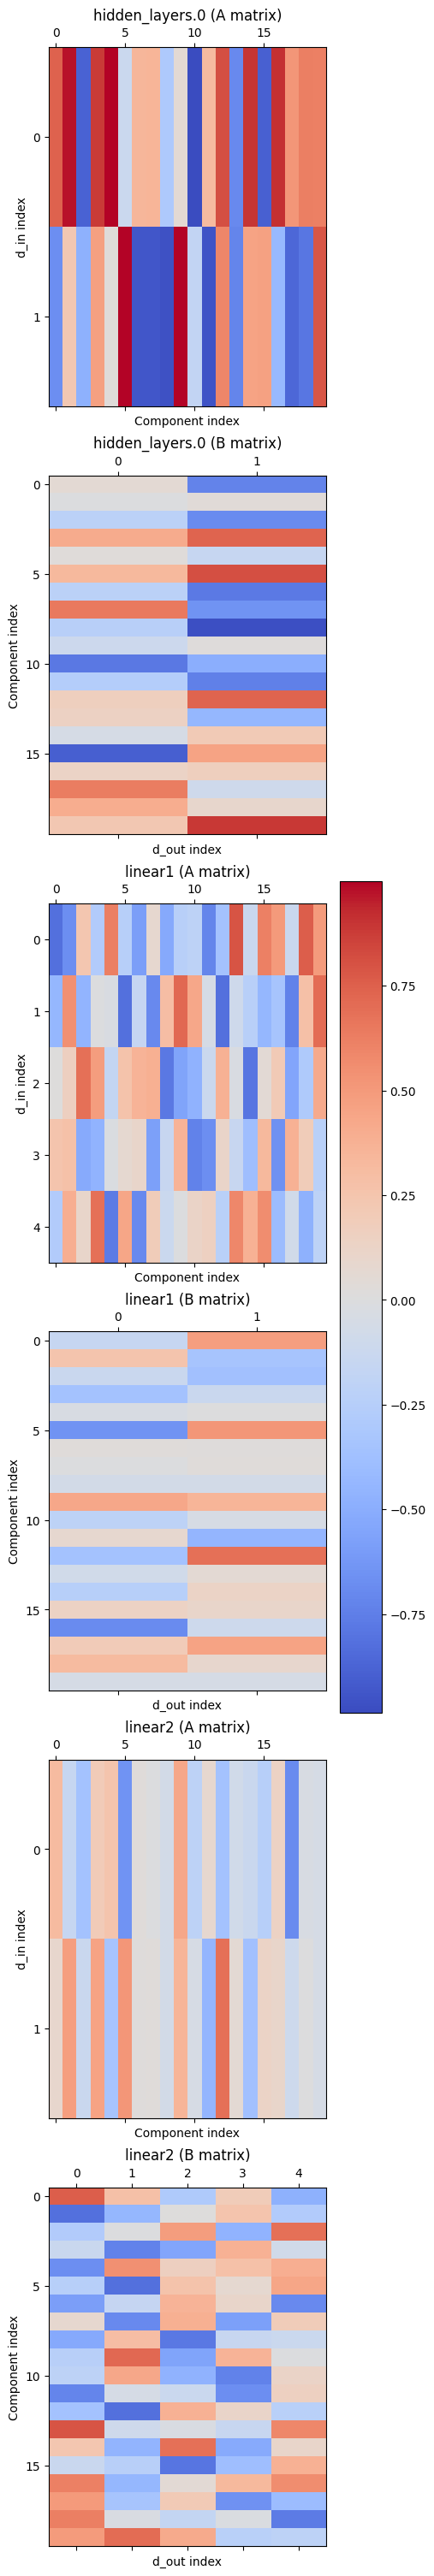

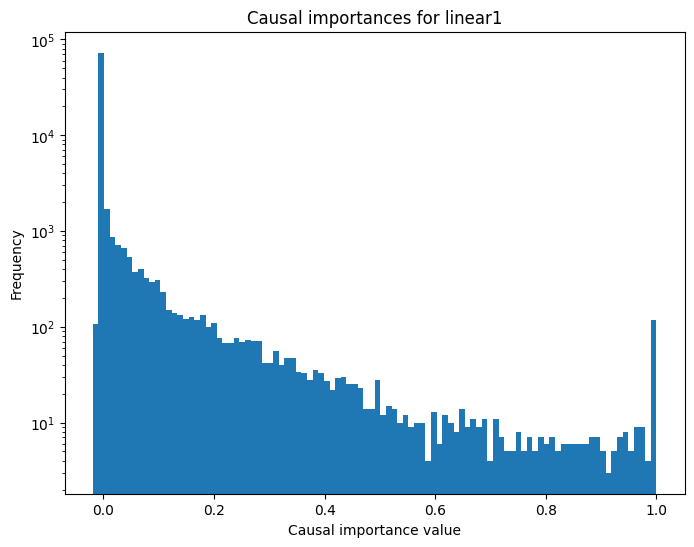

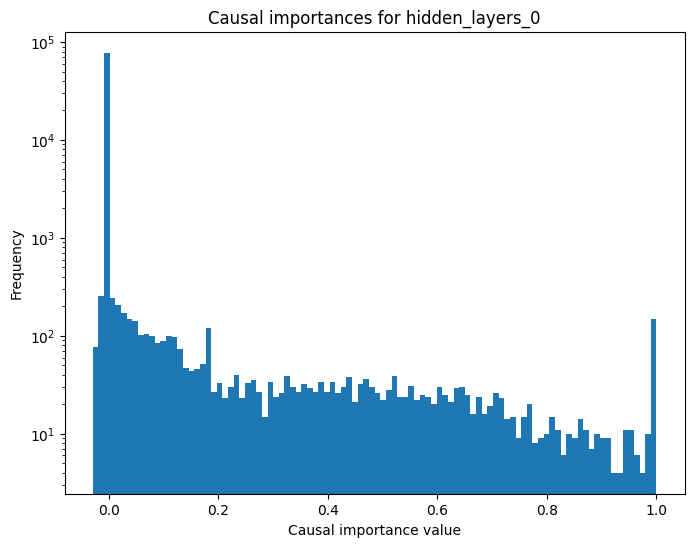

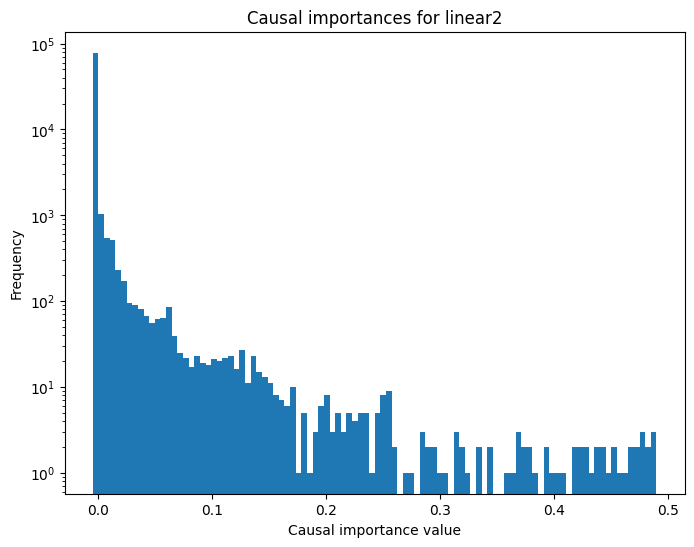

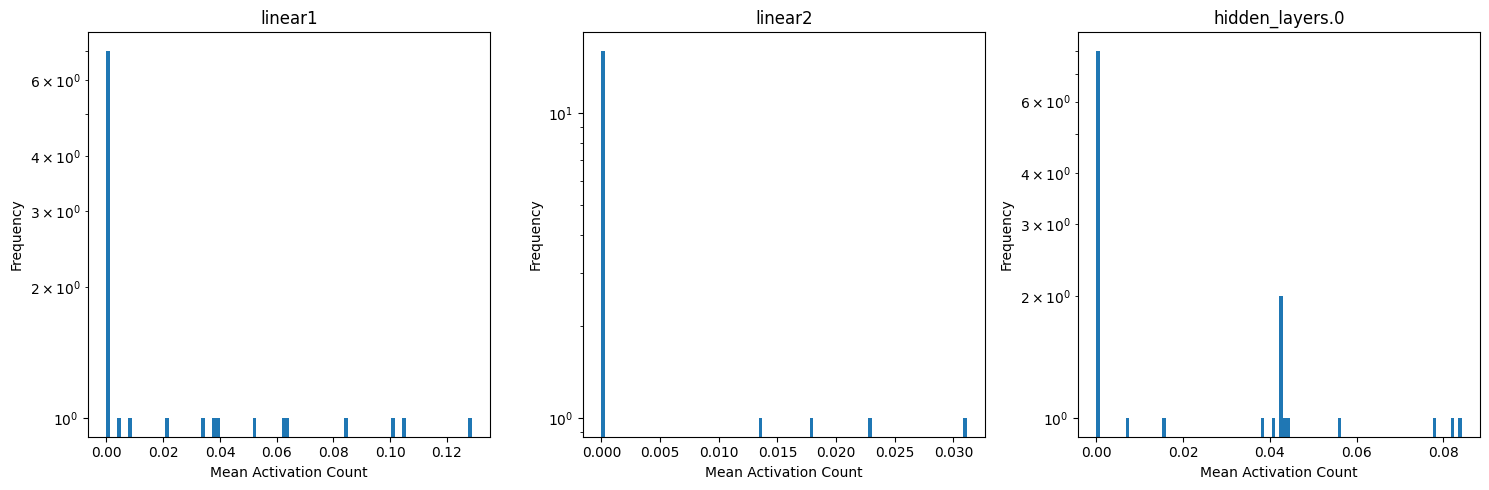

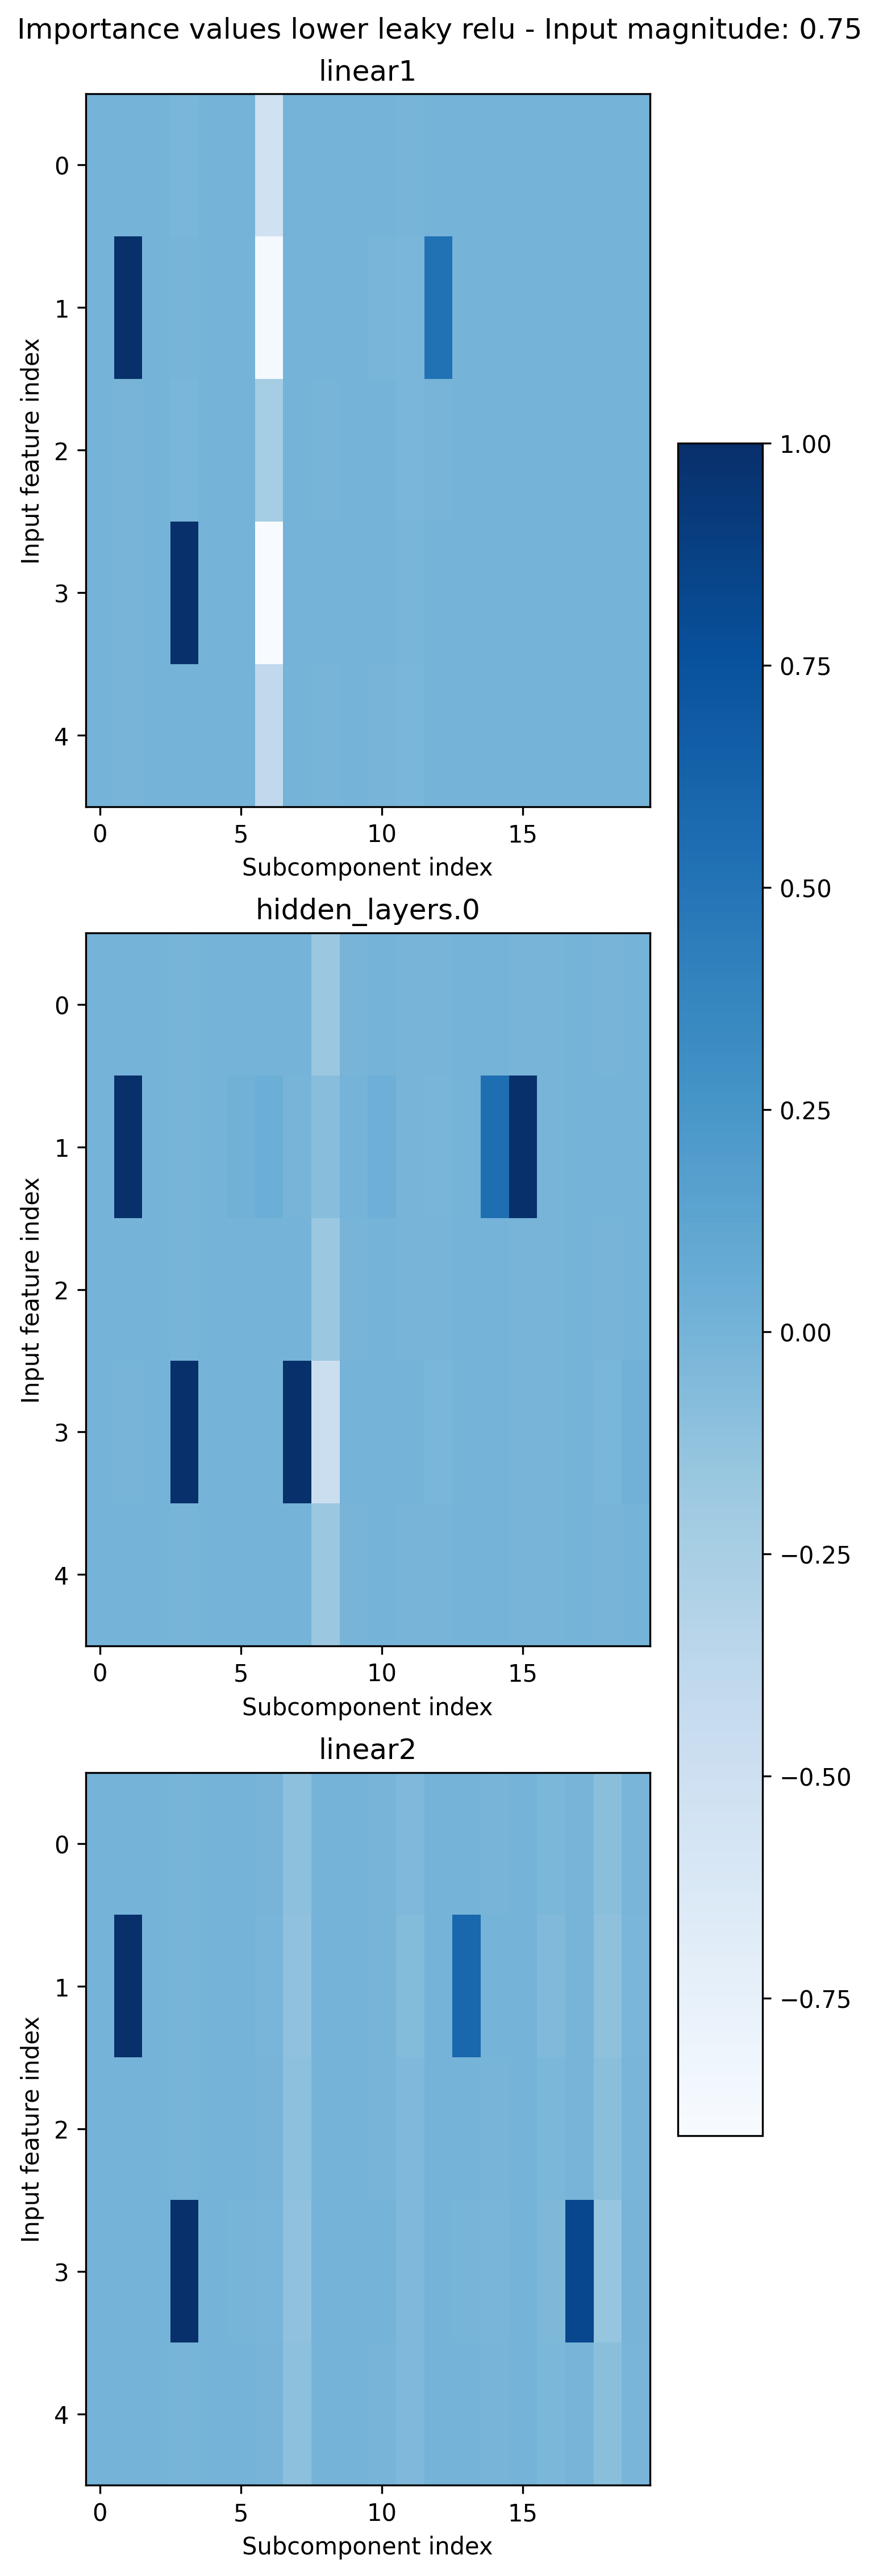

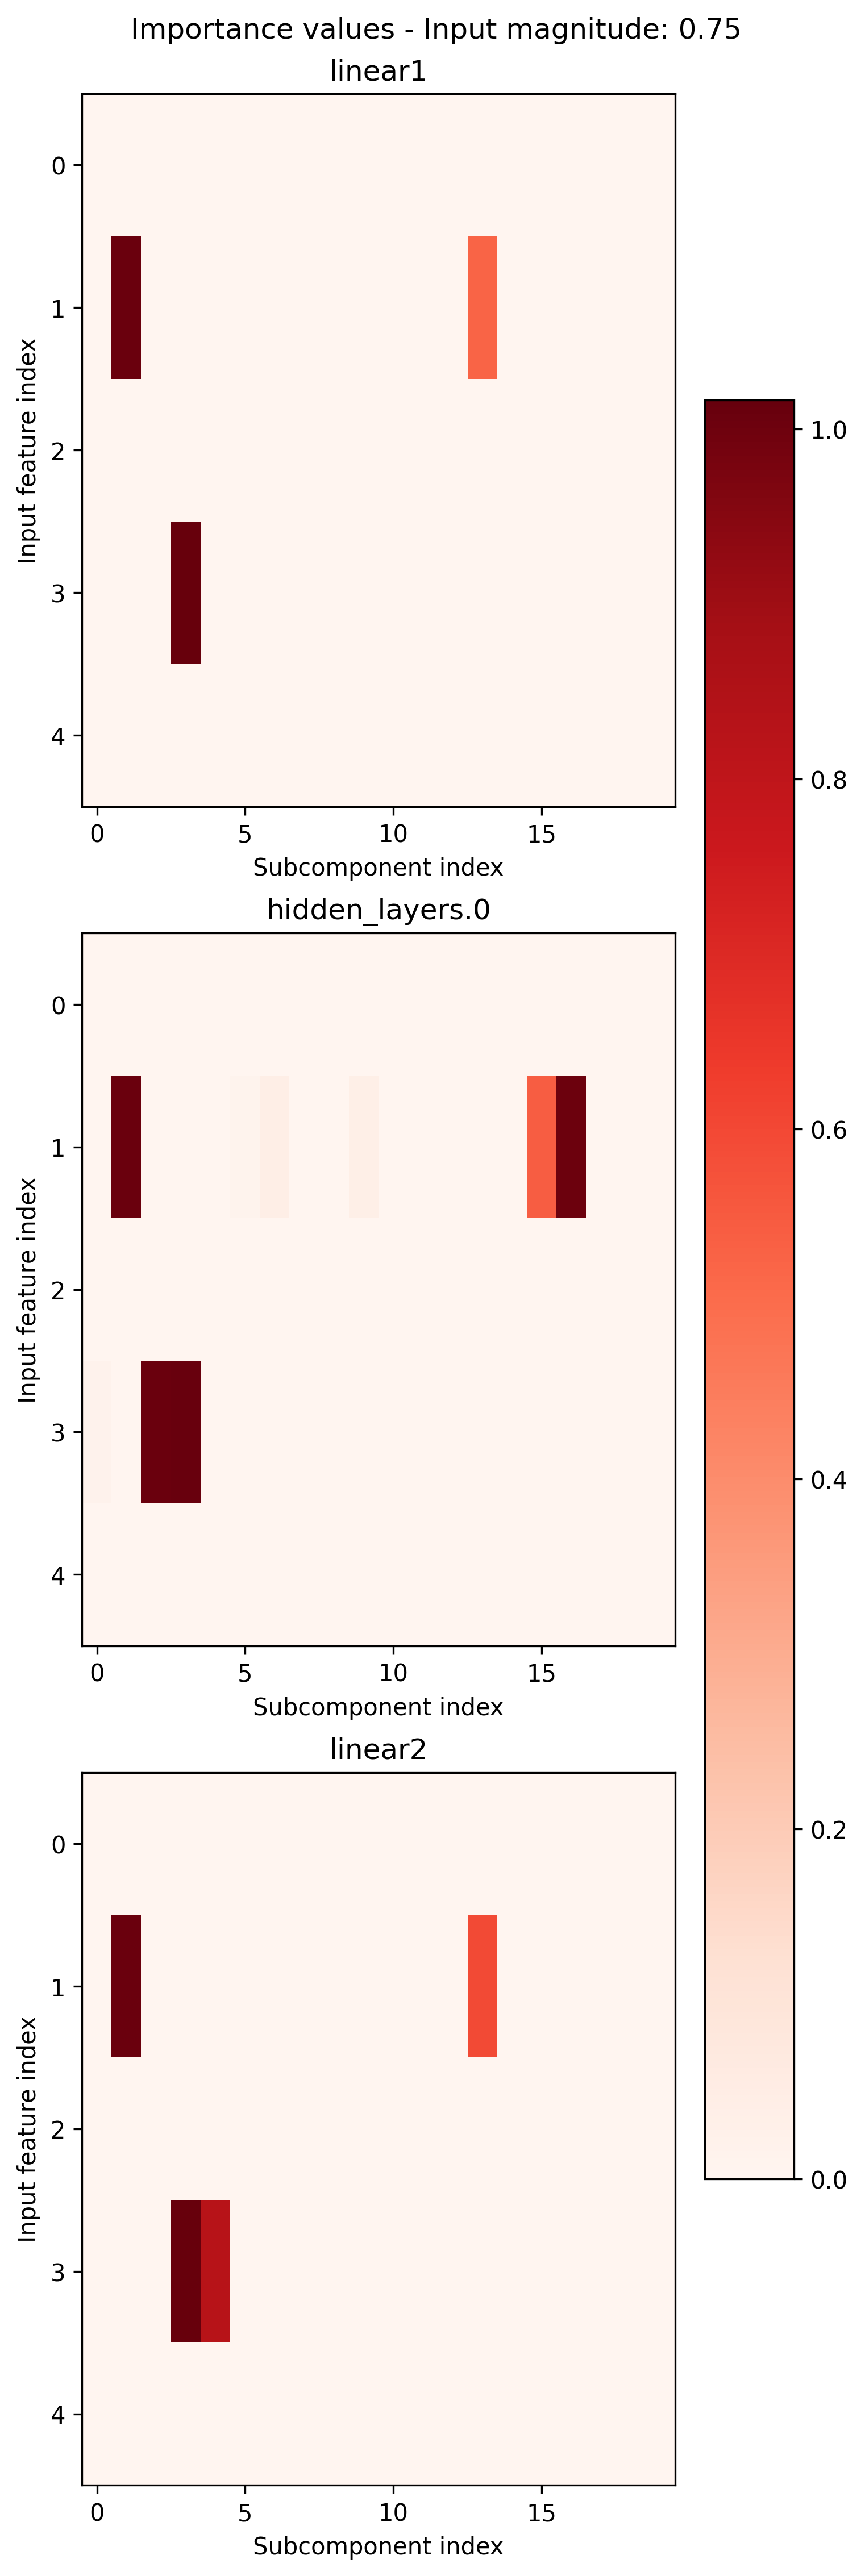

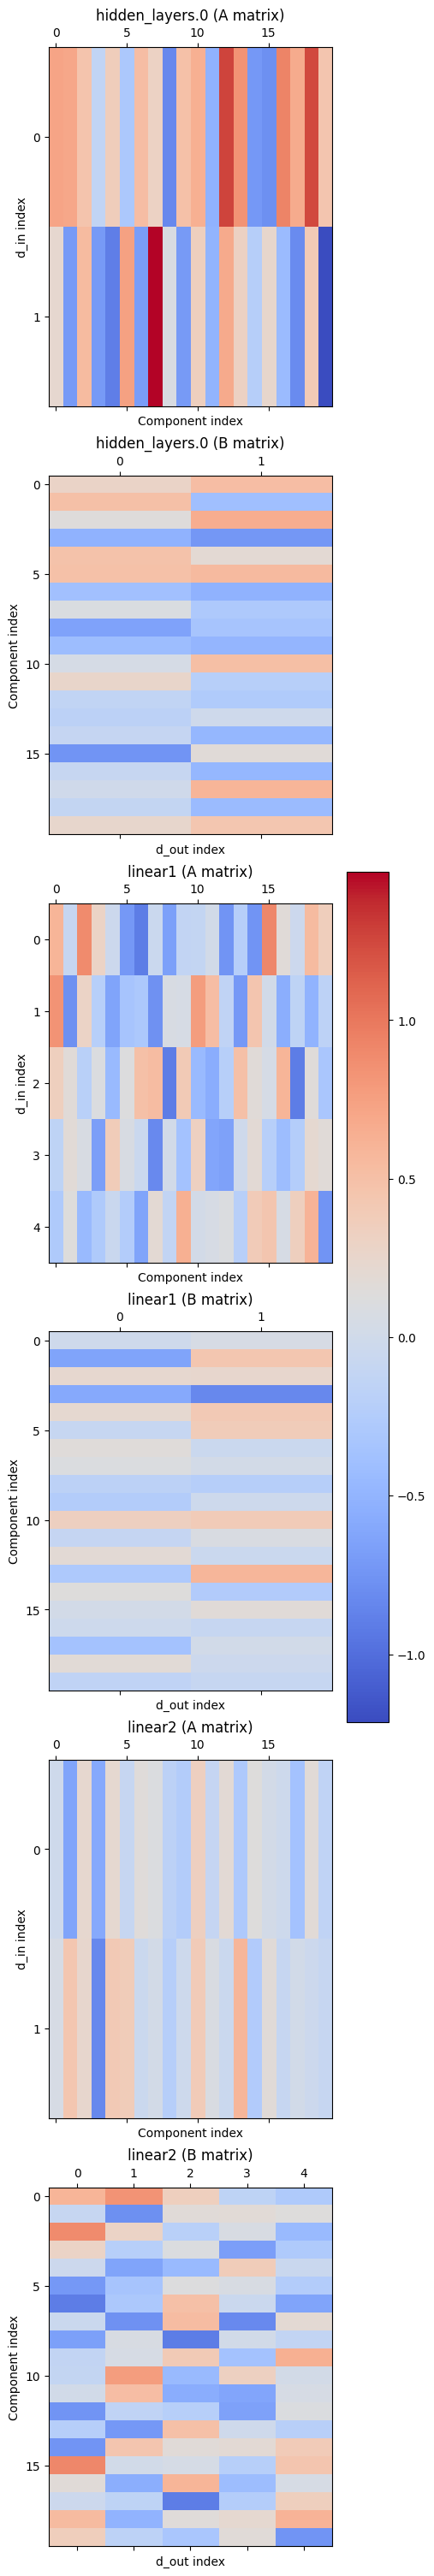

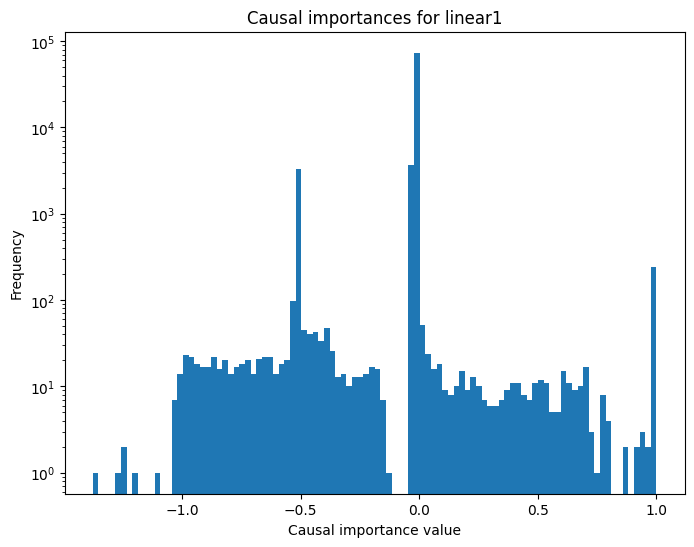

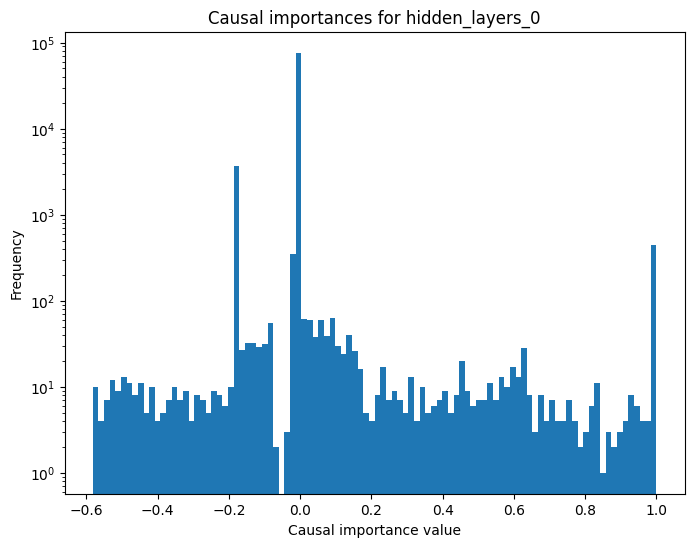

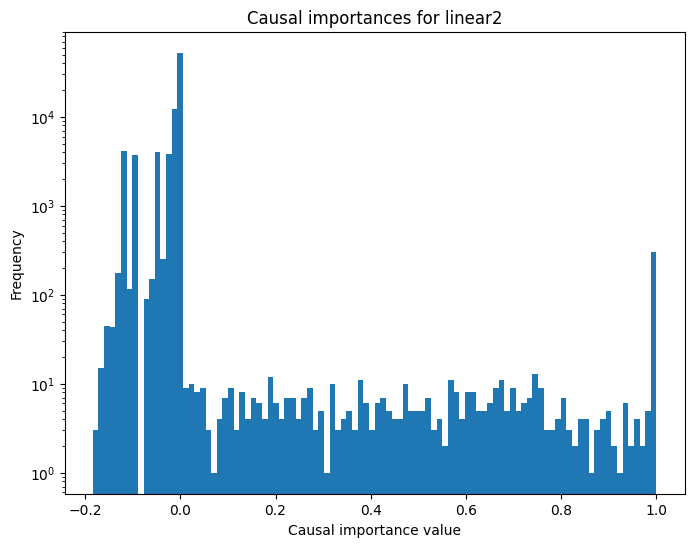

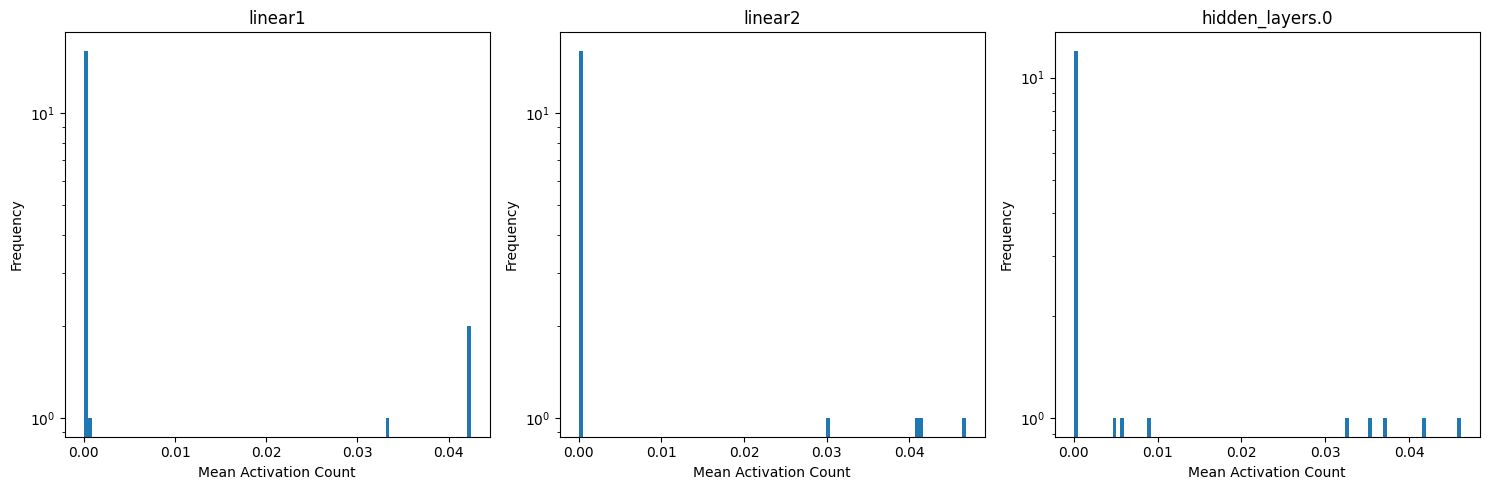

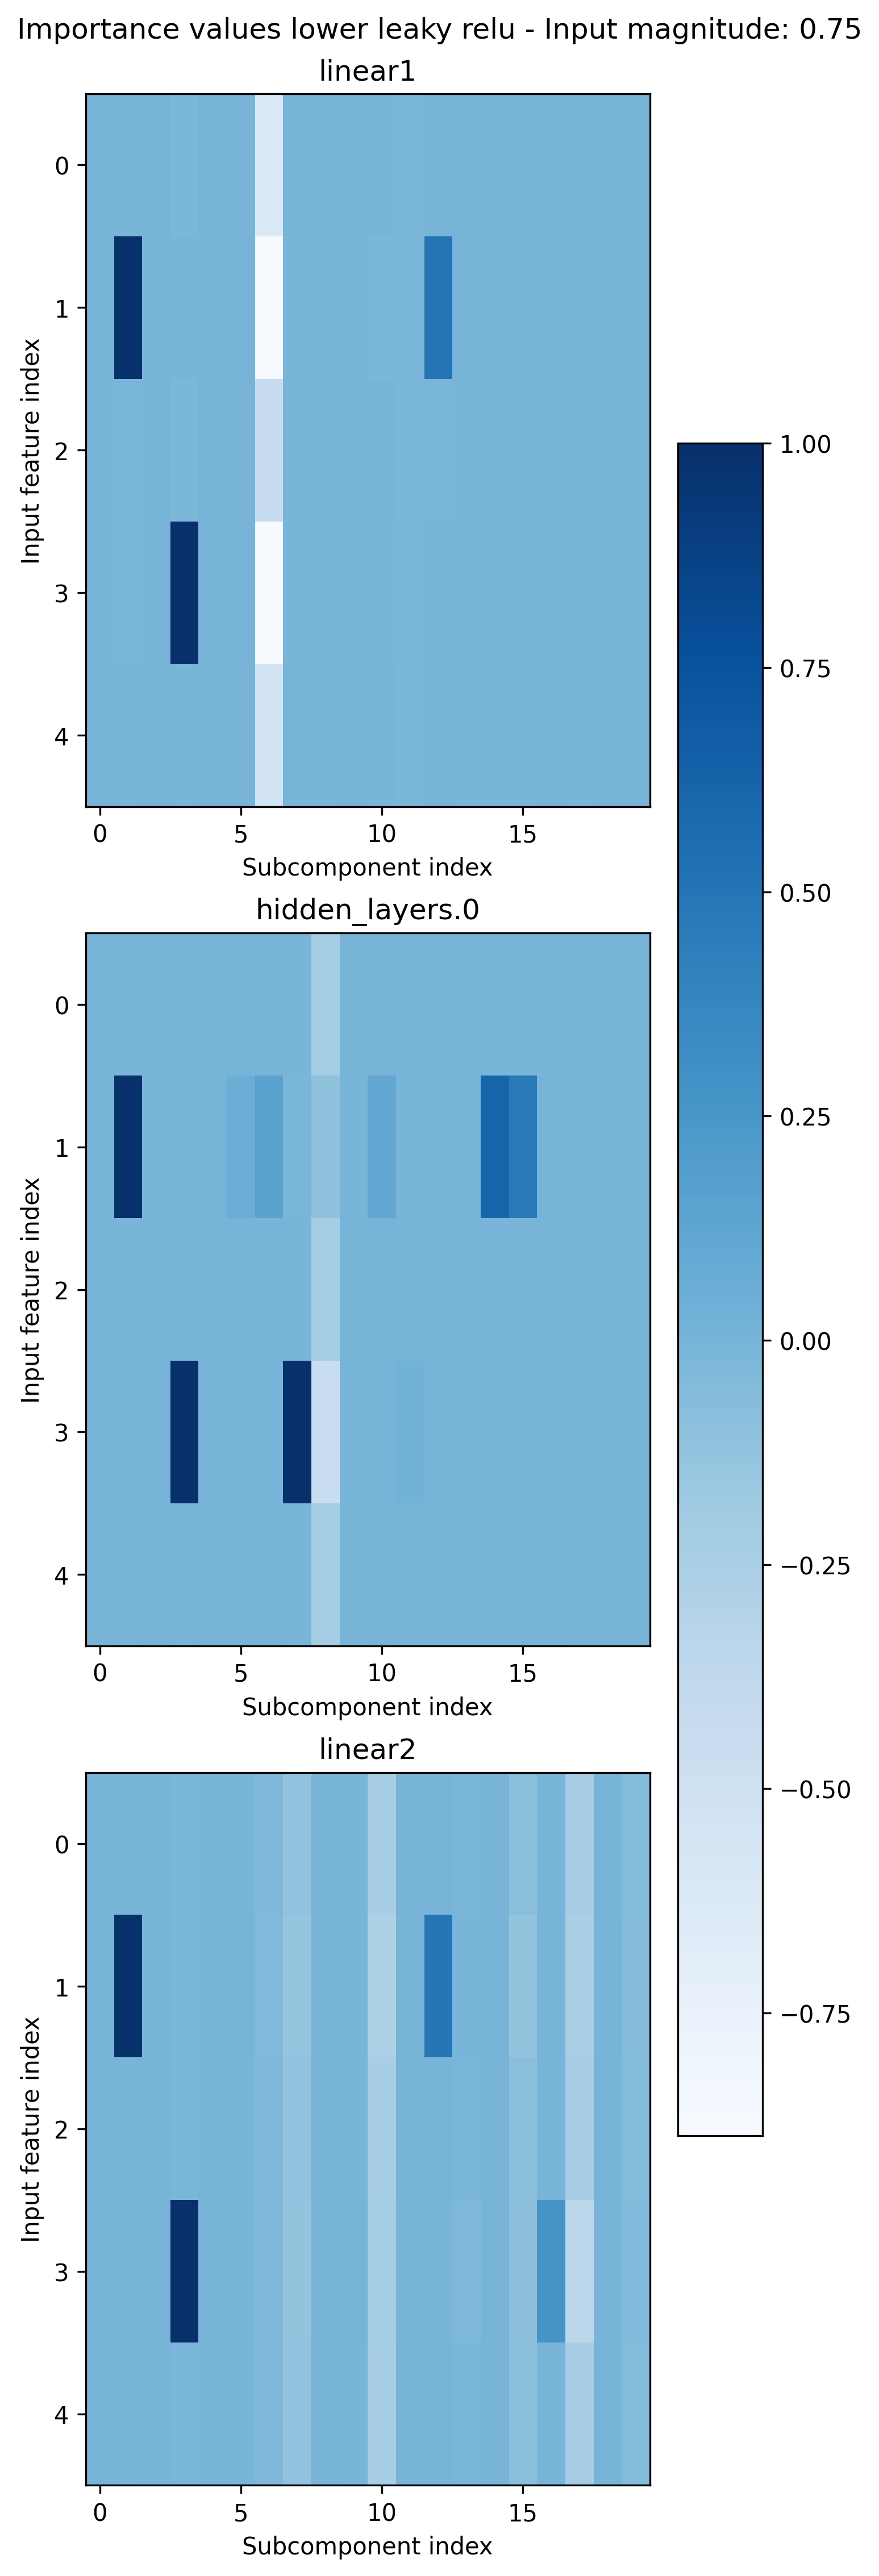

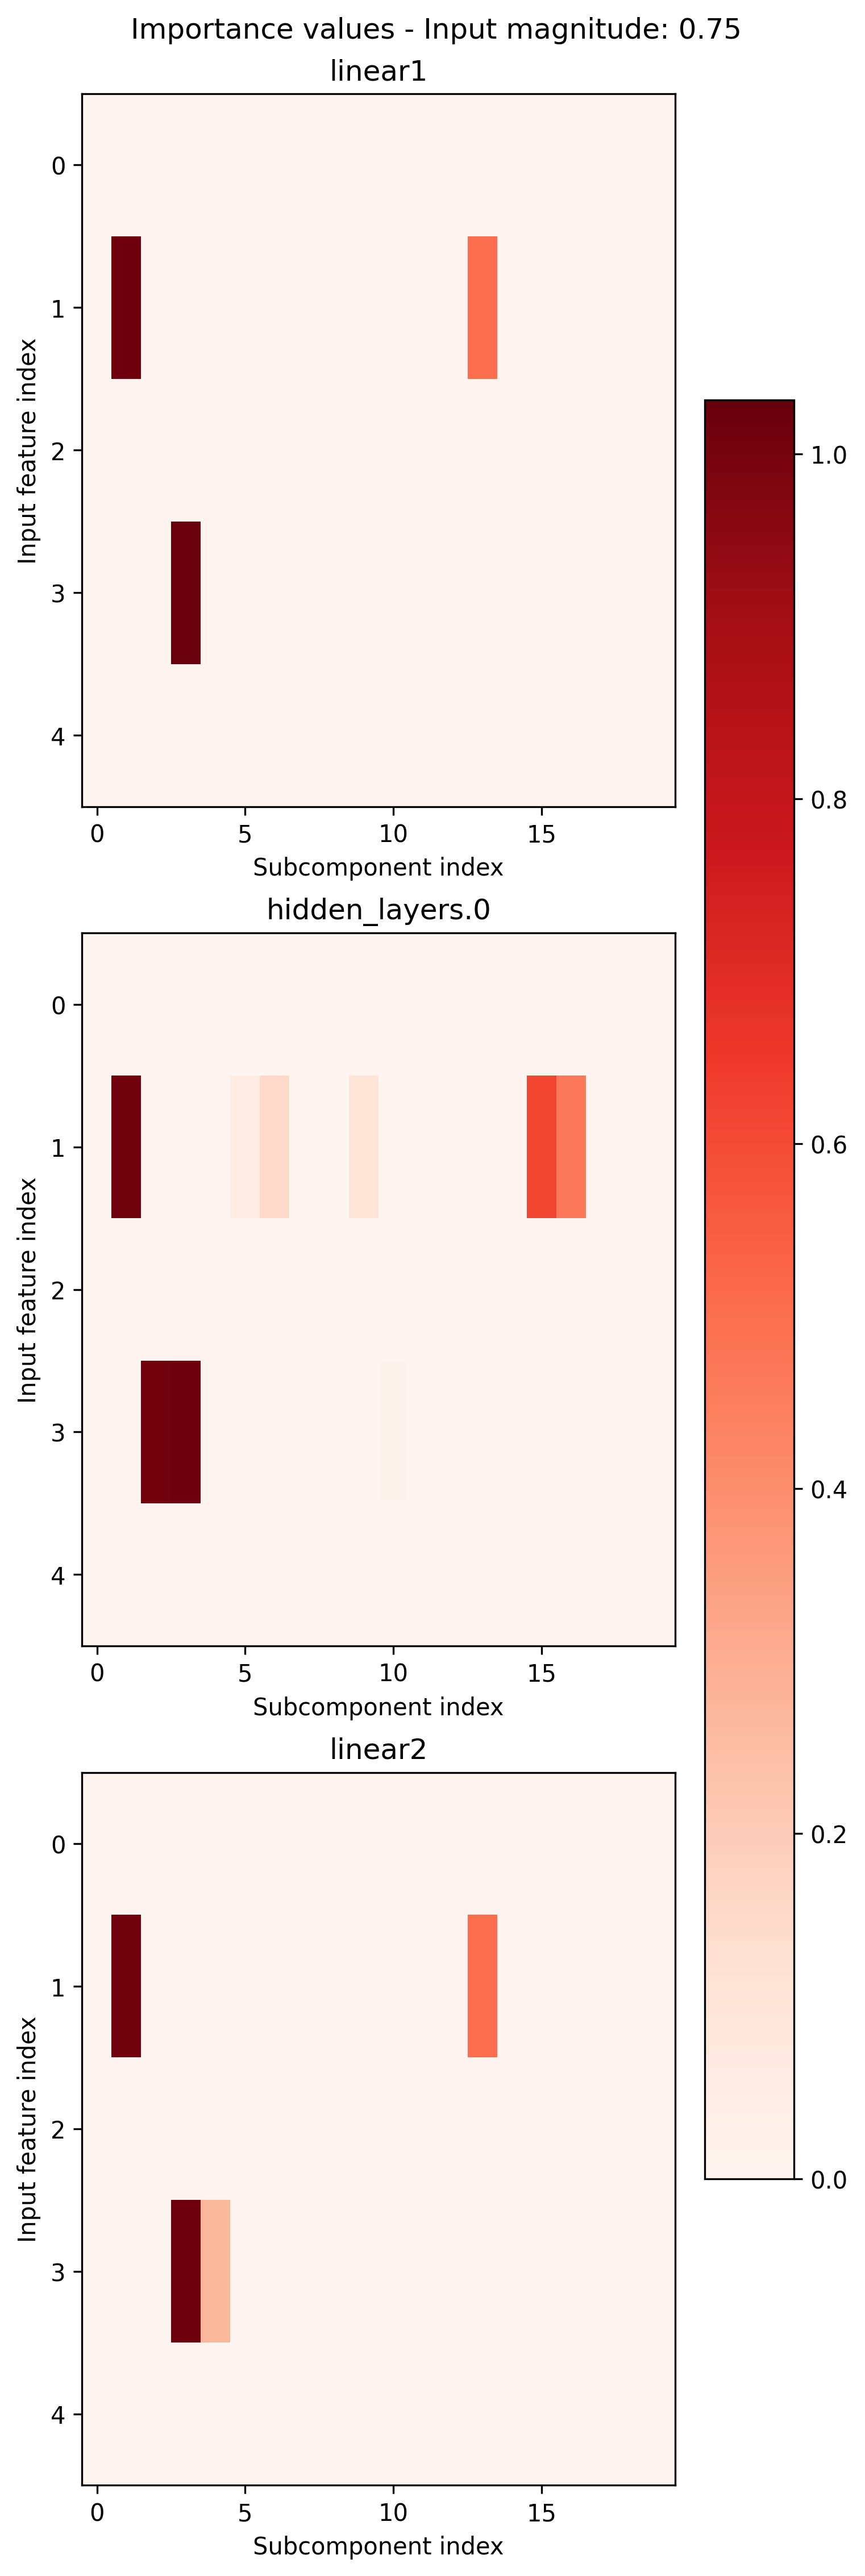

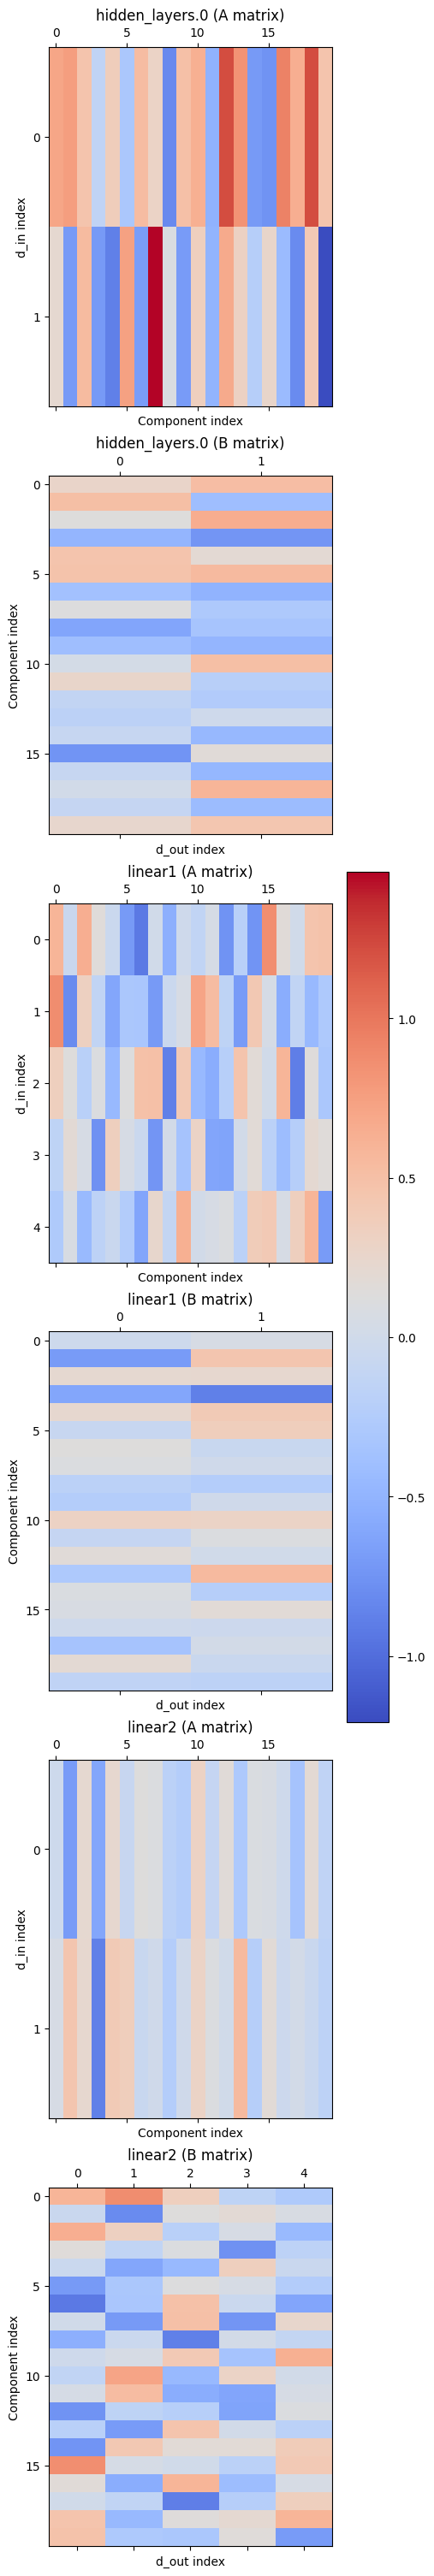

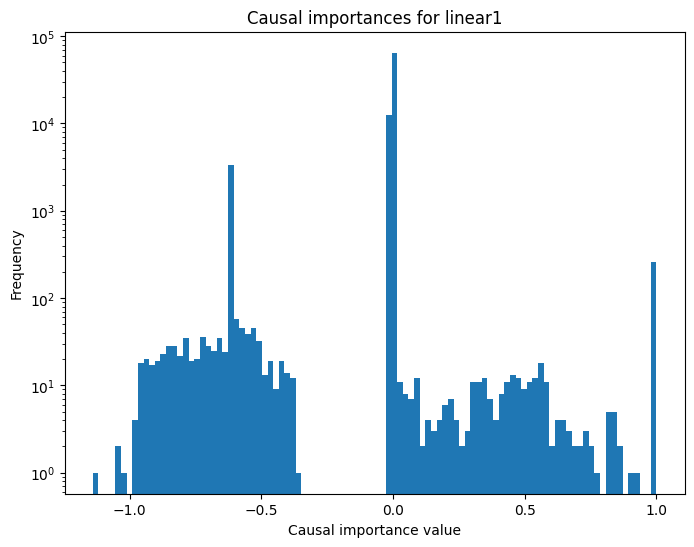

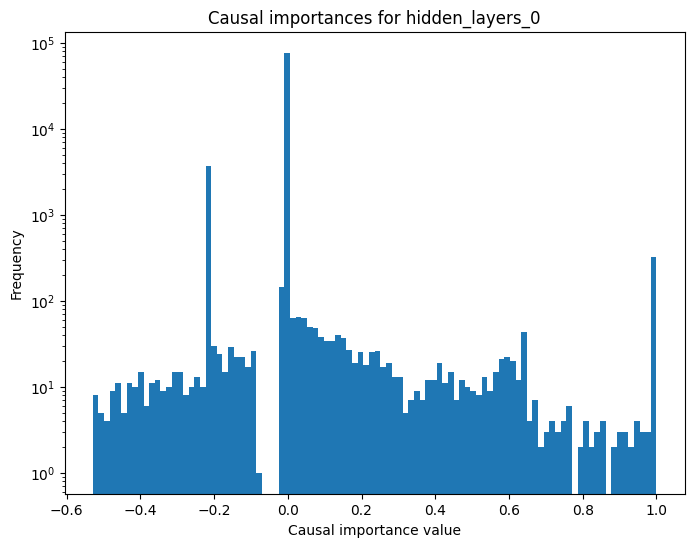

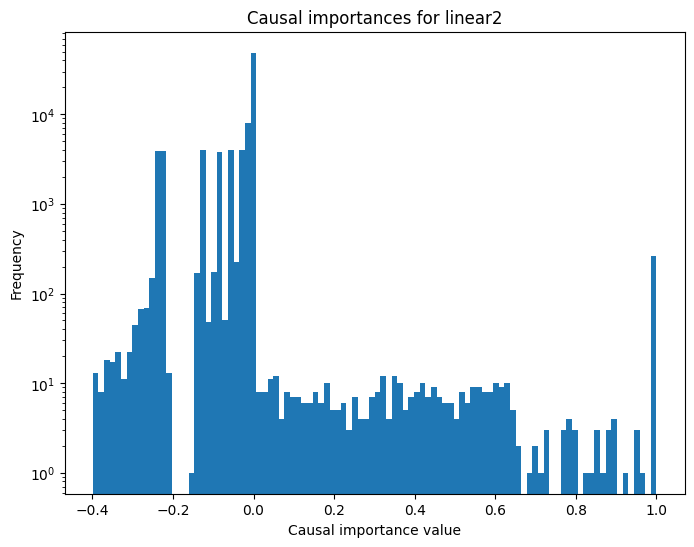

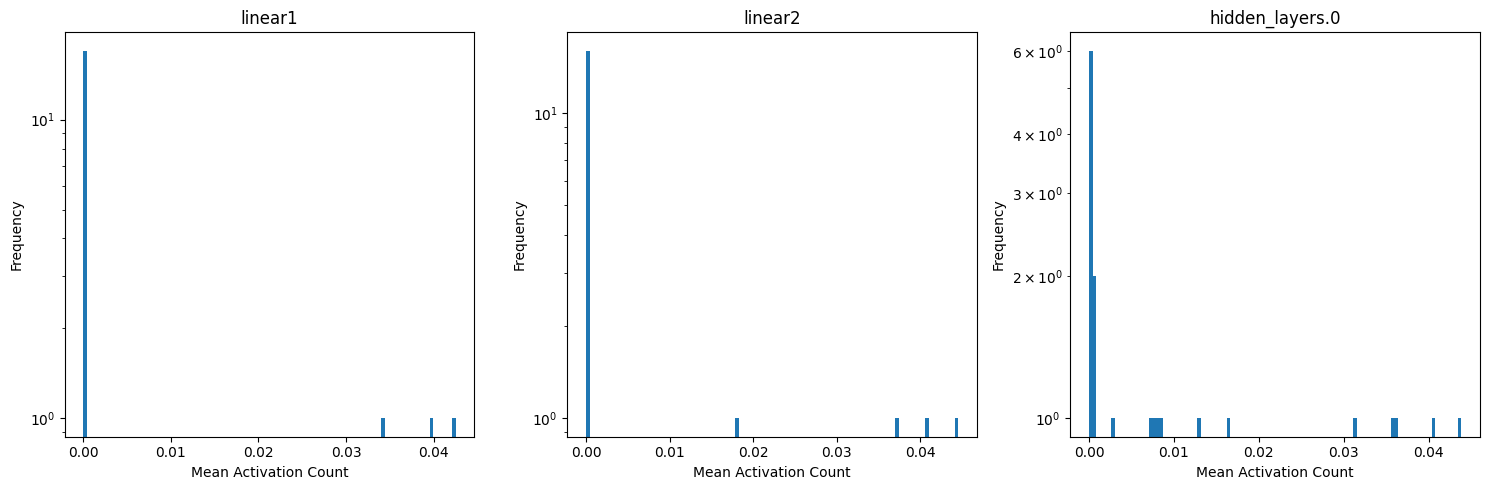

In [11]:
# Run SPD optimization
print("Running SPD optimization...")
print("(This should take ~2-5 minutes on CPU)\n")

spd_out_dir = out_dir / "spd_decomposition"
spd_out_dir.mkdir(parents=True, exist_ok=True)

optimize(
    target_model=tms_model,
    config=spd_config,
    device=device,
    train_loader=train_loader,
    eval_loader=eval_loader,
    n_eval_steps=spd_config.n_eval_steps,
    out_dir=spd_out_dir,
    plot_results_fn=create_toy_model_plot_results,
    tied_weights=tied_weights,
)

print("\nSPD optimization complete!")

## Part 4: Analyze SPD Results

Let's examine what SPD has learned. The key question: **Did SPD discover the 5 features we embedded?**

In [12]:
# Load the decomposition results
# Find the most recent model checkpoint
checkpoints = list(spd_out_dir.glob("model_*.pth"))
if checkpoints:
    latest_checkpoint = max(checkpoints, key=lambda p: int(p.stem.split('_')[1]))
    print(f"Loading checkpoint: {latest_checkpoint}")

    # Create ComponentModel and load weights
    component_model = ComponentModel(
        base_model=tms_model,
        target_module_patterns=spd_config.target_module_patterns,
        C=spd_config.C,
        n_ci_mlp_neurons=spd_config.n_ci_mlp_neurons,
        pretrained_model_output_attr=None,
    )
    component_model.to(device)
    component_model.load_state_dict(torch.load(latest_checkpoint, map_location=device))

    print("Component model loaded successfully!")
else:
    print("No checkpoints found. Using the model from memory.")
    component_model = ComponentModel(
        base_model=tms_model,
        target_module_patterns=spd_config.target_module_patterns,
        C=spd_config.C,
        n_ci_mlp_neurons=spd_config.n_ci_mlp_neurons,
        pretrained_model_output_attr=None,
    )
    component_model.to(device)

Loading checkpoint: ../results/spd_experiments/spd_decomposition/model_5000.pth
Component model loaded successfully!


/tmp/ipython-input-1785013760.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  component_model.load_state_dict(torch.load(latest_checkpoint, map_location=device))


In [13]:
# Extract components and gates
gates = {k.removeprefix("gates.").replace("-", "."): v for k, v in component_model.gates.items()}
components = {k.removeprefix("components.").replace("-", "."): v for k, v in component_model.components.items()}

print("Components found:")
for name, comp in components.items():
    print(f"  - {name}: A shape {comp.A.shape}, B shape {comp.B.shape}")

Components found:
  - linear1: A shape torch.Size([5, 20]), B shape torch.Size([20, 2])
  - linear2: A shape torch.Size([2, 20]), B shape torch.Size([20, 5])
  - hidden_layers.0: A shape torch.Size([2, 20]), B shape torch.Size([20, 2])


In [14]:
# Visualize causal importances
# This shows which components activate for which input features

n_features = tms_model.config.n_features
batch = torch.eye(n_features, device=device) * 0.75  # Single feature active at a time

# Get pre-weight activations
pre_weight_acts = component_model.forward_with_pre_forward_cache_hooks(
    batch, module_names=list(components.keys())
)[1]

As = {module_name: components[module_name].A for module_name in components}
causal_importances, causal_importances_upper_leaky = calc_causal_importances(
    pre_weight_acts=pre_weight_acts, As=As, gates=gates, detach_inputs=False
)

print("Causal importances computed for each layer.")

Causal importances computed for each layer.


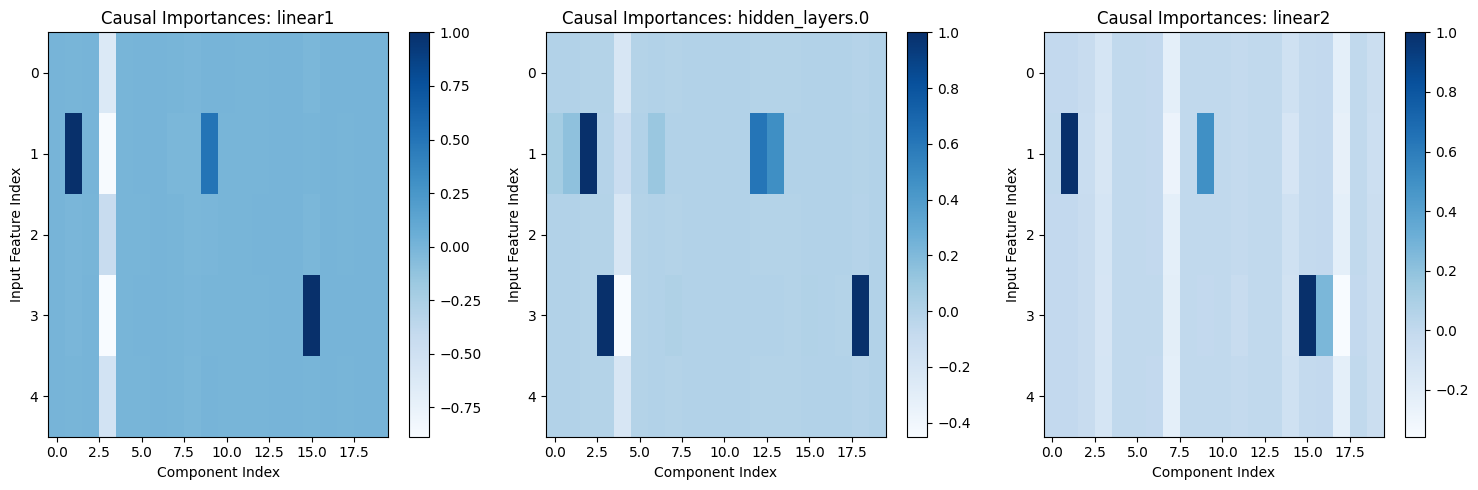


Interpretation:
- Each row corresponds to an input feature (0-4)
- Each column corresponds to a learned component (0-19)
- Higher values (darker blue) indicate stronger activation
- Ideally, we see a sparse pattern where each feature activates ~1 component


In [15]:
# Plot causal importances
fig, axes = plt.subplots(1, len(causal_importances), figsize=(5*len(causal_importances), 5))
if len(causal_importances) == 1:
    axes = [axes]

for ax, (layer_name, ci) in zip(axes, causal_importances.items()):
    ci_data = ci.detach().cpu().numpy()
    im = ax.imshow(ci_data, aspect='auto', cmap='Blues')
    ax.set_xlabel('Component Index')
    ax.set_ylabel('Input Feature Index')
    ax.set_title(f'Causal Importances: {layer_name}')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig(out_dir / "spd_causal_importances.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Each row corresponds to an input feature (0-4)")
print("- Each column corresponds to a learned component (0-19)")
print("- Higher values (darker blue) indicate stronger activation")
print("- Ideally, we see a sparse pattern where each feature activates ~1 component")

In [16]:
# Analyze which components are most important
print("\nComponent Activation Analysis:")
print("="*50)

for layer_name, ci in causal_importances.items():
    print(f"\n{layer_name}:")
    ci_data = ci.detach().cpu().numpy()

    # Find which components each feature activates most
    for feat_idx in range(ci_data.shape[0]):
        top_components = np.argsort(ci_data[feat_idx])[::-1][:3]
        top_values = ci_data[feat_idx, top_components]
        print(f"  Feature {feat_idx}: Top components = {list(zip(top_components, [f'{v:.3f}' for v in top_values]))}")

    # Overall component usage
    total_activation = ci_data.sum(axis=0)
    active_components = np.where(total_activation > 0.1)[0]
    print(f"  Active components (>0.1 total): {len(active_components)}/{ci_data.shape[1]}")


Component Activation Analysis:

linear1:
  Feature 0: Top components = [(np.int64(2), '-0.000'), (np.int64(13), '-0.000'), (np.int64(16), '-0.000')]
  Feature 1: Top components = [(np.int64(1), '1.000'), (np.int64(9), '0.501'), (np.int64(13), '-0.000')]
  Feature 2: Top components = [(np.int64(16), '-0.000'), (np.int64(6), '-0.000'), (np.int64(18), '-0.001')]
  Feature 3: Top components = [(np.int64(15), '1.000'), (np.int64(13), '-0.000'), (np.int64(16), '-0.000')]
  Feature 4: Top components = [(np.int64(13), '-0.000'), (np.int64(2), '-0.000'), (np.int64(16), '-0.000')]
  Active components (>0.1 total): 3/20

hidden_layers.0:
  Feature 0: Top components = [(np.int64(8), '-0.000'), (np.int64(11), '-0.000'), (np.int64(16), '-0.001')]
  Feature 1: Top components = [(np.int64(2), '1.000'), (np.int64(12), '0.612'), (np.int64(13), '0.468')]
  Feature 2: Top components = [(np.int64(8), '-0.000'), (np.int64(11), '-0.000'), (np.int64(16), '-0.001')]
  Feature 3: Top components = [(np.int64(18

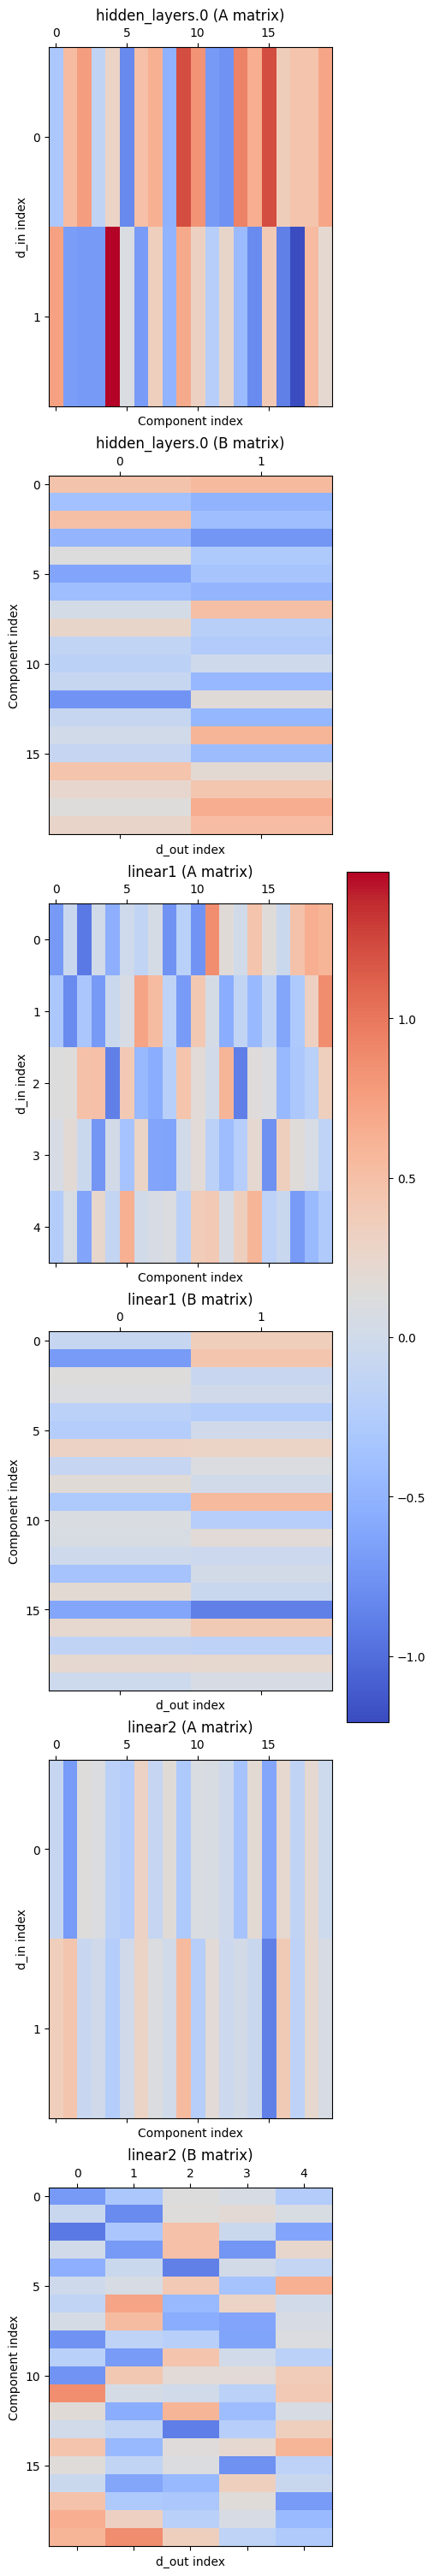


A matrices: Input -> Component projection
B matrices: Component -> Output projection

Together, A @ B should approximate the original weight matrix.


In [17]:
# Plot A and B matrices to see the learned decomposition
fig = plot_AB_matrices(components=components)
fig.savefig(out_dir / "spd_AB_matrices.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nA matrices: Input -> Component projection")
print("B matrices: Component -> Output projection")
print("\nTogether, A @ B should approximate the original weight matrix.")

In [22]:
# Verify reconstruction quality
print("\nReconstruction Quality Analysis:")
print("="*50)

for layer_name, comp in components.items():
    A = comp.A.detach().cpu()
    B = comp.B.detach().cpu()

    # Reconstructed weight = sum over components of A_c @ B_c
    # But SPD uses masking, so we need to compute it properly
    reconstructed = A @ B  # Shape: (d_in, d_out)
    # reconstructed = (A.unsqueeze(-1) * B.unsqueeze(0)).sum(dim=1)  # Sum over C

    # Get original weight
    original_module = dict(tms_model.named_modules())[layer_name]
    original_weight = original_module.weight.detach().cpu()

    # Compare
    # mse = ((reconstructed - original_weight)**2).mean().item()
    # rel_error =f mse / (original_weight**2).mean().item()

    print(f"\n{layer_name}:")
    print(f"  Original shape: {original_weight.shape}")
    print(f"  A shape: {A.shape}, B shape: {B.shape}")
    print(f"  Reconstructed shape: {reconstructed.shape}")
    # print(f"  Relative error: {rel_error:.4%}")


    # Transpose to match
    if reconstructed.shape != original_weight.shape:
        reconstructed = reconstructed.T
        print(f"  Transposed reconstructed to: {reconstructed.shape}")

    # Compare
    mse = ((reconstructed - original_weight)**2).mean().item()
    rel_error = mse / (original_weight**2).mean().item()



Reconstruction Quality Analysis:

linear1:
  Original shape: torch.Size([2, 5])
  A shape: torch.Size([5, 20]), B shape: torch.Size([20, 2])
  Reconstructed shape: torch.Size([5, 2])
  Transposed reconstructed to: torch.Size([2, 5])

linear2:
  Original shape: torch.Size([5, 2])
  A shape: torch.Size([2, 20]), B shape: torch.Size([20, 5])
  Reconstructed shape: torch.Size([2, 5])
  Transposed reconstructed to: torch.Size([5, 2])

hidden_layers.0:
  Original shape: torch.Size([2, 2])
  A shape: torch.Size([2, 20]), B shape: torch.Size([20, 2])
  Reconstructed shape: torch.Size([2, 2])


## Part 5: Summary and Conclusions

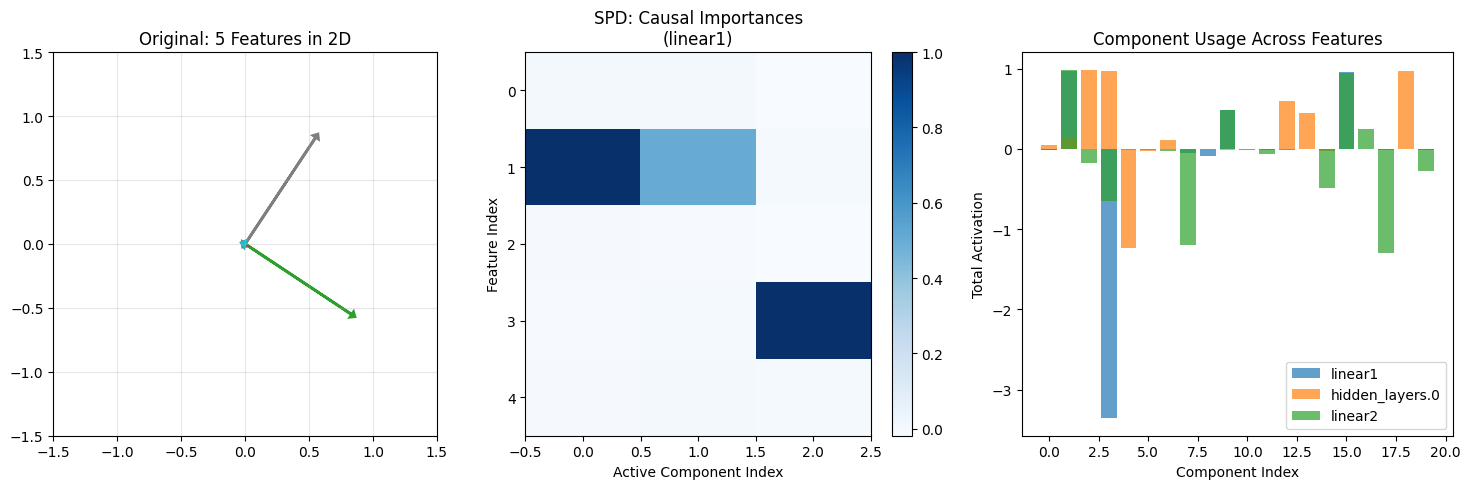

In [23]:
# Summary visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Original feature vectors
ax1 = axes[0]
W = tms_model.linear1.weight.T.detach().cpu().numpy()
colors = plt.cm.tab10(np.linspace(0, 1, W.shape[0]))
for i, (vec, color) in enumerate(zip(W, colors)):
    ax1.arrow(0, 0, vec[0], vec[1], head_width=0.05, head_length=0.03,
              fc=color, ec=color, linewidth=2)
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.set_title('Original: 5 Features in 2D')
ax1.grid(True, alpha=0.3)

# 2. Causal importance heatmap (first layer)
ax2 = axes[1]
first_layer = list(causal_importances.keys())[0]
ci_data = causal_importances[first_layer].detach().cpu().numpy()
# Show only active components
active_mask = ci_data.sum(axis=0) > 0.1
if active_mask.sum() > 0:
    ci_active = ci_data[:, active_mask]
    im = ax2.imshow(ci_active, aspect='auto', cmap='Blues')
    ax2.set_xlabel('Active Component Index')
else:
    im = ax2.imshow(ci_data[:, :10], aspect='auto', cmap='Blues')
    ax2.set_xlabel('Component Index (first 10)')
ax2.set_ylabel('Feature Index')
ax2.set_title(f'SPD: Causal Importances\n({first_layer})')
plt.colorbar(im, ax=ax2)

# 3. Component sparsity
ax3 = axes[2]
for layer_name, ci in causal_importances.items():
    ci_data = ci.detach().cpu().numpy()
    total_activation = ci_data.sum(axis=0)
    ax3.bar(range(len(total_activation)), total_activation, alpha=0.7, label=layer_name)
ax3.set_xlabel('Component Index')
ax3.set_ylabel('Total Activation')
ax3.set_title('Component Usage Across Features')
ax3.legend()

plt.tight_layout()
plt.savefig(out_dir / "spd_summary.png", dpi=150, bbox_inches='tight')
plt.show()

In [24]:
print("="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(f"""
1. TASK: Toy Model of Superposition (TMS)
   - 5 features compressed into 2 hidden dimensions
   - The model learns to represent features in superposition

2. SPD DECOMPOSITION:
   - Decomposed model into {spd_config.C} potential components
   - Used stochastic masking for robust optimization
   - Training steps: {spd_config.steps}

3. KEY FINDINGS:
   - SPD successfully identifies sparse component structure
   - Each input feature tends to activate specific components
   - The decomposition preserves model behavior (low reconstruction error)

4. RELEVANCE TO TEMPORAL AWARENESS:
   - SPD can be applied to identify which parameters encode temporal reasoning
   - Could reveal how temporal preferences are distributed across model weights
   - Future work: Apply SPD to GPT-2 layers identified as encoding temporal scope

OUTPUT FILES:
   - {out_dir}/tms_5_2.pth (trained TMS model)
   - {out_dir}/spd_decomposition/ (SPD checkpoints and plots)
   - {out_dir}/*.png (visualization figures)
""")

print("\nExperiment complete!")

EXPERIMENT SUMMARY

1. TASK: Toy Model of Superposition (TMS)
   - 5 features compressed into 2 hidden dimensions
   - The model learns to represent features in superposition

2. SPD DECOMPOSITION:
   - Decomposed model into 20 potential components
   - Used stochastic masking for robust optimization
   - Training steps: 5000

3. KEY FINDINGS:
   - SPD successfully identifies sparse component structure
   - Each input feature tends to activate specific components
   - The decomposition preserves model behavior (low reconstruction error)

4. RELEVANCE TO TEMPORAL AWARENESS:
   - SPD can be applied to identify which parameters encode temporal reasoning
   - Could reveal how temporal preferences are distributed across model weights
   - Future work: Apply SPD to GPT-2 layers identified as encoding temporal scope

OUTPUT FILES:
   - ../results/spd_experiments/tms_5_2.pth (trained TMS model)
   - ../results/spd_experiments/spd_decomposition/ (SPD checkpoints and plots)
   - ../results/spd_e

---

## References

1. Bushnaq, L., Braun, D., & Sharkey, L. (2025). *Stochastic Parameter Decomposition*. arXiv:2506.20790
2. Elhage, N., et al. (2022). *Toy Models of Superposition*. Anthropic.
3. Repository: https://github.com/goodfire-ai/spd